In [21]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn 
from PIL import Image
import numpy as np
from torch.utils.data import random_split, Subset, Dataset
import os
import matplotlib.pyplot as plt
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [22]:
import torch.utils
import torch.utils.data


train_transform = transforms.Compose([
    # 几何变换（作用于PIL Image）
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5, fill=0),
    
    # 颜色变换（作用于PIL Image）
    transforms.ColorJitter(brightness=0.15, contrast=0.1, saturation=0.1),

    # 高斯模糊
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    
    # 调整锐度
    # transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    
    # 转换为张量（必须在此之后的操作均作用于Tensor)
    transforms.ToTensor(),
    
    # 张量操作（需在ToTensor之后）
    # transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), value="random"),
    transforms.Normalize(
        mean=[0.4113, 0.3563, 0.3150],
        std=[0.2779, 0.2487, 0.2356]
    )
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4113, 0.3563, 0.3150],
        std=[0.2779, 0.2487, 0.2356]
    )
])

In [23]:
def visualization(image, transform, num_samples=5):
    plt.figure(figsize=(15, 6))
    plt.subplot(3, 6, 1)
    plt.axis('off') 
    plt.imshow(image)
    plt.title('initial')

    for i in range(num_samples):
        augmented = transform(image)
        if isinstance(augmented, torch.Tensor):
            augmented = transforms.ToPILImage()(augmented)
        plt.subplot(3, 6, i+2)
        plt.axis('off') 
        plt.imshow(augmented)
        plt.title(f'transform{i+1}')

    plt.tight_layout()
    plt.show()

In [24]:
# image, label = dataset[0]
# visualization(image, train_transform, 17)

# plt.imshow(image)
# plt.axis('off')

In [25]:
class CustomImageFloder(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
dataset = datasets.ImageFolder('/kaggle/input/face-data')
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in indices]
train_val_dataset, test_dataset = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, stratify=[dataset.targets[i] for i in train_val_dataset], random_state=42)

In [27]:
# len(train_dataset), len(val_dataset), len(test_dataset)
# image, label = dataset[0]
# image, label

In [28]:
train_dataset = CustomImageFloder(dataset, train_dataset, train_transform)
val_dataset = CustomImageFloder(dataset, val_dataset, test_transform)
test_dataset = CustomImageFloder(dataset, test_dataset, test_transform)

In [29]:
# train_size = int(len(dataset) * 0.7)
# val_size = int(len(dataset) * 0.1)
# test_size = int(len(dataset) * 0.2)
# train_datasets, val_datasets, test_datasets = random_split(dataset, [train_size, val_size, test_size])

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:

# for data, target in test_loader:
#     print(f'image size: {data.size()}')
#     print(f"target: {target}")
#     break
# print(len(dataset.classes))
# print(len(dataset))

In [32]:
# for batch in train_loader:
#     images, labels = batch
#     assert (labels >= 0).all() and (labels <= 214).all(), "标签越界"
#     assert labels.dtype == torch.int64, "标签需为 LongTensor"

In [33]:
# mean = 0.0
# std = 0.0
# n_samples = 0
# for data, _ in train_loader:
#     n_samples += data.shape[0]
#     data = data.view(data.shape[0], data.shape[1], -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
# mean = mean / n_samples
# std = std / n_samples
# print(f"Mean: {mean}")
# print(f"Std: {std}")

In [34]:
class Residual(nn.Module):
    def __init__(self, input_channels, output_channels, use_conv3=False ,stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        if use_conv3:
            self.conv3 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=1, stride=2)
        else:
            self.conv3 = None
    
    def forward(self, X):
        Y = self.bn1(self.conv1(X))
        Y = self.relu(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(X + Y)

In [35]:
class ResNet(nn.Module):
    def __init__(self, block, layer, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)

        self.layer1 = nn.Sequential(*self._make_layer(block, 64, layer[0], first_block=True))
        self.layer2 = nn.Sequential(*self._make_layer(block, 128, layer[1]))
        self.layer3 = nn.Sequential(*self._make_layer(block, 256, layer[2]))
        self.layer4 = nn.Sequential(*self._make_layer(block, 512, layer[3]))

        self.adpavgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, out_channels, blocks, stride=1, first_block=False):
        layers = []
        for i in range(blocks):
            if i == 0 and not first_block:
                layers.append(block(self.in_channels, out_channels, use_conv3=True, stride=2))
                self.in_channels = out_channels
            else:
                layers.append(block(self.in_channels, out_channels, stride=1))
        return layers
    
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.adpavgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [36]:
model = ResNet(Residual, [2,2,2,2], num_classes=215)
X = torch.rand((1, 3, 224, 224))
model(X)

tensor([[ 1.5945e+00, -2.4731e-01, -5.5191e-01, -5.2400e-01,  3.7687e-01,
         -7.4923e-01, -5.2821e-02,  1.9730e-01, -2.4850e-02, -6.9402e-01,
         -1.5327e-01,  3.8750e-01, -9.2953e-01, -1.1323e+00,  7.5742e-01,
          8.8177e-01,  8.2608e-01, -1.3491e-01, -8.6748e-01,  2.3093e-01,
         -9.6136e-02, -5.6722e-01,  3.3180e-01, -5.0675e-01, -1.1966e-01,
          4.5371e-01,  9.9818e-02,  1.4062e-01, -6.0999e-01,  1.2063e+00,
         -6.3055e-01,  1.6201e-01, -8.1530e-01, -3.6258e-01,  1.4734e-01,
         -2.4267e-01, -3.4471e-01,  2.6481e-01,  3.6851e-01,  1.0096e+00,
         -8.5413e-01,  1.2692e-01,  4.1683e-01, -1.5468e-01, -3.2246e-02,
          4.5206e-02,  4.5622e-01, -3.5851e-01,  7.5438e-01, -7.0500e-01,
         -8.5077e-01, -1.9282e-01, -2.2108e-01,  8.3014e-01,  3.0921e-01,
          3.3031e-01, -5.5239e-01,  1.2537e-02,  1.3252e-01, -8.3027e-02,
         -6.8102e-01,  6.6756e-04, -2.4800e-01,  2.2463e-01, -2.3370e-01,
         -8.2991e-01, -1.8989e-01,  3.

In [37]:
class LabelSmoothLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothLoss, self).__init__()
        self.confidence = 1 - smoothing
        self.smoothing = smoothing
        self.classes = classes
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_list = torch.zeros_like(pred)
            true_list.fill_(self.smoothing / (self.classes - 1))
            true_list.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_list * pred, dim=-1))
        

In [38]:
x = [1, 2]
x = torch.Tensor(x)
x.unsqueeze(1)

tensor([[1.],
        [2.]])

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(Residual, [2,2,2,2], 215)
# if torch.cuda.device_count() > 1:
#     print("use muti-GPU")
#     model = nn.DataParallel(model)
model.to(device)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothLoss(215, 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)


In [40]:
best_val_loss = float('inf')  
patience = 15                  
counter = 0  
train_losses = []
test_losses = []
for epoch in range(200):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    

    model.eval()
    with torch.no_grad():
        acc = 0.0
        test_loss = 0.0
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            test_loss += loss.item()
            acc += (pred.argmax(dim=1) == y).sum().item()
        test_losses.append(test_loss / len(val_loader))
   
    print(f"Epoch: {epoch + 1}, train_loss: {train_loss / len(train_loader):.4f}, test_loss: {test_loss / len(val_loader):.4f}, Accuracy: {acc / len(val_loader.dataset)}")
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        torch.save(model.state_dict(), 'ResNet18.pth')
    else:
        counter += 1
        if counter >= patience:
            print("EarlyStopping")
            break

Epoch: 1, train_loss: 5.6364, test_loss: 5.3660, Accuracy: 0.00909090909090909
Epoch: 2, train_loss: 5.3995, test_loss: 5.2796, Accuracy: 0.013636363636363636
Epoch: 3, train_loss: 5.2262, test_loss: 5.1926, Accuracy: 0.04090909090909091
Epoch: 4, train_loss: 5.0898, test_loss: 5.0430, Accuracy: 0.05
Epoch: 5, train_loss: 4.9331, test_loss: 4.9481, Accuracy: 0.05
Epoch: 6, train_loss: 4.8424, test_loss: 4.9921, Accuracy: 0.04090909090909091
Epoch: 7, train_loss: 4.6705, test_loss: 4.8639, Accuracy: 0.045454545454545456
Epoch: 8, train_loss: 4.5668, test_loss: 4.7273, Accuracy: 0.08181818181818182
Epoch: 9, train_loss: 4.4817, test_loss: 4.6651, Accuracy: 0.07727272727272727
Epoch: 10, train_loss: 4.3429, test_loss: 4.7291, Accuracy: 0.05909090909090909
Epoch: 11, train_loss: 4.1954, test_loss: 4.5981, Accuracy: 0.08636363636363636
Epoch: 12, train_loss: 4.1177, test_loss: 4.4106, Accuracy: 0.08636363636363636
Epoch: 13, train_loss: 4.0238, test_loss: 4.3395, Accuracy: 0.118181818181818

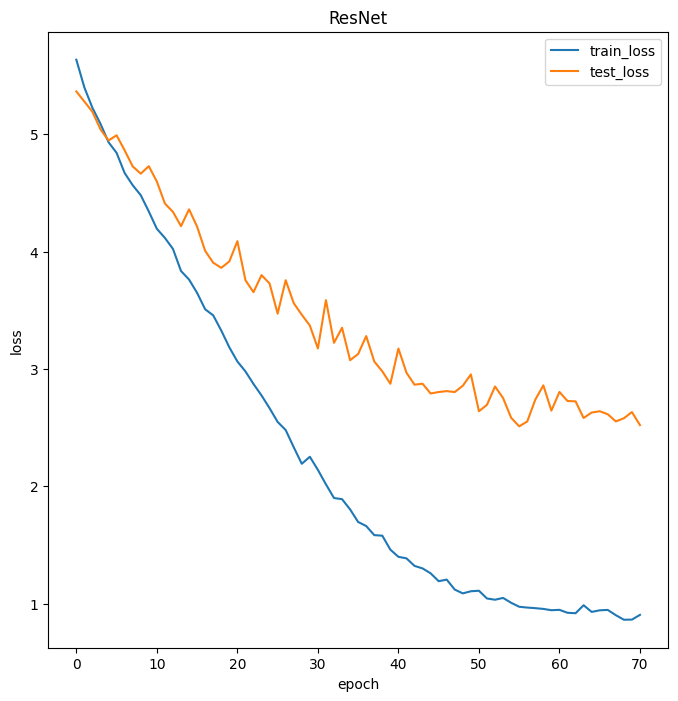

In [41]:
plt.figure(figsize=(8, 8))
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('ResNet')
plt.legend()
plt.show()

In [42]:
model.load_state_dict(torch.load('ResNet18.pth'))
model.eval()
with torch.no_grad():
    acc = 0.0
    test_loss = 0.0
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        test_loss += loss.item()
        acc += (pred.argmax(dim=1) == y).sum().item()
    print(f"test_loss: {test_loss / len(test_loader):.4f}, Accuracy: {acc / len(test_loader.dataset)}")

test_loss: 2.3855, Accuracy: 0.5382513661202186
